In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import trompy as tp
import csv
from datetime import datetime, timedelta


# the next two lines will expand the printed tables
pd.options.display.max_rows= 40000
pd.options.display.max_columns= 40000


ctl_color= "gray"
exp_color="deepskyblue"
fig_folder=r"../plots\\"
READ_METAFILE= pd.read_excel(r"..\FEDXD_METAFILE.xls" ,sheet_name="METAFILE" )

#READ_METAFILE


[Link to Choice_1](#Choice_1)

[Link to Choice_2](#Choice_2)


In [17]:
metafile_path = "../FEDXD_METAFILE.xls"  # Adjusted path to the uploaded file
rows, header = tp.metafilereader(metafile_path, sheetname="METAFILE")

def get_FEDevents(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:  # Check if rows is empty
        print(f"No data in file {filename}.")
        return []

    # Assuming the first column contains the date and time info
    # and the "Event" column is consistent with the provided files
    event_column_index = 9  # Based on your CSV structure
    
    # Determine which date format should be used (assuming consistency, so just using one format)
    date_format = formats[0]

    timestamps = []
    for row in rows:
        if row[event_column_index] == eventname:
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if not timestamps:  # If no events match, return an empty list
        return []

    # Calculate time since "lights on", using the first event as reference if needed
    t0 = timestamps[0].strftime(date_format)
    day = t0.split()[0]
    lightson = day + " 07:00:00"  # Assuming lights on at 7 AM
    refpoint = datetime.strptime(lightson, date_format)

    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]

    return pellettimes
# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Iterate through the rows to process and group data
for row in rows:
    mouse_id = row[0]
    sex = row[1]  # Assuming this is the correct column for SEX
    diet = row[7]  # Assuming this is the correct column for DIET
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"


    # Create a unique key for each group
    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect timestamps for this row's file and pellet event
    timestamps = get_FEDevents(filename, "Pellet")
    pellet_count = len(timestamps)
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "COUNT": pellet_count
    })

# cell below takes "number of pellets per hour" and stores them separately hour by hour

In [4]:


def get_FEDevents_hourly(filename, eventname):
    formats = ['%m/%d/%Y %H:%M:%S']  # Adjusted to the format in your CSV
    file = open(filename)
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = [row for row in csvreader]

    if not rows:
        print(f"No data in file {filename}.")
        return []

    event_column_index = 9
    date_format = formats[0]

    timestamps = [datetime.strptime(row[0], date_format) for row in rows if row[event_column_index] == eventname]
    
    if not timestamps:
        return []

    # Sort timestamps to ensure chronological order
    timestamps.sort()

    # Calculate hourly counts, ignoring the first and last hour
    first_event_time = timestamps[0]
    last_event_time = timestamps[-1]
    current_time = first_event_time + timedelta(hours=1)  # Start from the second hour
    end_time = last_event_time  # Include events up to the last hour

    hourly_counts = []
    while current_time < end_time:
        next_hour = current_time + timedelta(hours=1)
        count = sum(1 for t in timestamps if current_time <= t < next_hour)
        hourly_counts.append(count)
        current_time = next_hour

    # Remove the count for the last hour, as we need to ignore it
    if hourly_counts:
        hourly_counts = hourly_counts[:-1]

    return hourly_counts

# Initialize a dictionary to hold lists for each unique group
grouped_lists = {}

# Assuming you've already read the metadata into `rows`
for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    group_key = f"{sex}_{diet}_{choice_session}_{pellet_type}"
    
    # Collect hourly pellet counts for this row's file and pellet event
    hourly_counts = get_FEDevents_hourly(filename, "Pellet")
    
    # Initialize the list for this group if it doesn't exist
    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    # Append the data for this mouse to the list for its group
    grouped_lists[group_key].append({
        "MOUSEID": mouse_id,
        "SEX": sex,
        "DIET": diet,
        "CHOICE_SESSION": choice_session,
        "PELLET_TYPE": pellet_type,
        "HOURLY_COUNTS": hourly_counts
    })


In [5]:
# Flatten the grouped_lists into a list of dictionaries
data_to_convert = []
for group_key, records in grouped_lists.items():
    for record in records:
        # Decompose the group_key back into its components if needed
        sex, diet, choice_session, pellet_type = group_key.split("_")
        # Create a new dictionary for each record that includes the group information
        record_data = {
            "MOUSEID": record["MOUSEID"],
            "SEX": record["SEX"],
            "DIET": record["DIET"],
            "CHOICE_SESSION": record["CHOICE_SESSION"],
            "PELLET_TYPE": record["PELLET_TYPE"],
            "HOURLY_COUNTS": record["HOURLY_COUNTS"]
        }
        # Append the new dictionary to the list
        data_to_convert.append(record_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data_to_convert)




if not df.empty and "HOURLY_COUNTS" in df.columns and df["HOURLY_COUNTS"].apply(len).max() > 0:
    max_length = df["HOURLY_COUNTS"].apply(len).max()
    hourly_counts_df = pd.DataFrame(df["HOURLY_COUNTS"].tolist(), index=df.index,
                                    columns=[f"Hour_{i+1}" for i in range(max_length)])
    df_hourly_pellet = pd.concat([df.drop(columns=["HOURLY_COUNTS"]), hourly_counts_df], axis=1)

# Show the DataFrame structure (optional)
print(df_hourly_pellet.head())

   MOUSEID SEX DIET  CHOICE_SESSION PELLET_TYPE  Hour_1  Hour_2  Hour_3  \
0  FEDXDF1   F   PR             0.0         MIX     7.0     0.0    22.0   
1  FEDXDF1   F   PR             0.0         MIX     0.0     0.0     2.0   
2  FEDXDF2   F   PR             0.0         MIX    30.0     3.0     0.0   
3  FEDXDF2   F   PR             0.0         MIX     2.0     2.0     0.0   
4  FEDXDF3   F   PR             0.0         MIX    23.0     9.0     1.0   

   Hour_4  Hour_5  Hour_6  Hour_7  Hour_8  Hour_9  Hour_10  Hour_11  Hour_12  \
0     0.0     0.0     9.0    10.0    10.0     9.0      8.0     10.0     17.0   
1     2.0     0.0     0.0     3.0     0.0    10.0      4.0      9.0      5.0   
2     3.0     2.0     4.0     5.0     6.0    10.0     23.0     14.0     22.0   
3     0.0     0.0     1.0     0.0     1.0     1.0      5.0     15.0     11.0   
4    21.0     2.0     4.0    17.0     0.0    10.0     16.0     15.0     22.0   

   Hour_13  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  Hour_19  Ho

In [9]:
df_hourly_pellet
df_hourly_pellet.to_csv('../results/HOURLY_PELLET.csv', index=False)

# cells below measures components of a meal such as size, frequency and number FROM TWO FEDs in choices

In [18]:
def get_FEDevents(filename, eventname, formats=['%m/%d/%Y %H:%M:%S']):
    path = os.path.join("../data", filename)  # Ensure path is correctly specified
    timestamps = []
    with open(path) as file:
        csvreader = csv.reader(file)
        next(csvreader)  # Skip header
        rows = [row for row in csvreader if row[9] == eventname]
    timestamps = [datetime.strptime(row[0], formats[0]) for row in rows]
    
    if not timestamps:
        return [], None
    
    refpoint = timestamps[0].replace(hour=7, minute=0, second=0, microsecond=0)
    pellettimes = [(t - refpoint).total_seconds() / 3600 for t in timestamps]
    return pellettimes, refpoint

def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60, min_pellets_for_meal=1):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, [0]*24)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    current_event = [pellettimes[0]]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) >= min_pellets_for_meal:
                meals.append(current_event)
            else:
                snacks.append(current_event)
            current_event = [pellettimes[i + 1]]

    if current_event:
        if len(current_event) >= min_pellets_for_meal:
            meals.append(current_event)
        else:
            snacks.append(current_event)

    nmeals = len(meals)
    nsnacks = len(snacks)
    hourly_meals = np.zeros(24)
    for meal in meals:
        start_hour = int(meal[0]) % 24
        hourly_meals[start_hour] += 1

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else total_pellets / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0

    return mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals.tolist()

# Assuming 'rows' contains your metafile data
grouped_lists = {}

for row in rows:
    mouse_id = row[0]
    sex = row[1]
    diet = row[7]
    choice_session = row[4]
    pellet_type = row[5]
    filename = f"../data/{row[3]}"

    # Use a common group key for sessions 1, 2, 3, 4, regardless of pellet type
    if choice_session in [1, 2, 3, 4]:
        group_key = f"{mouse_id}_{sex}_{diet}_{choice_session}"
    else:
        group_key = f"{mouse_id}_{sex}_{diet}_{choice_session}_{pellet_type}"

    if group_key not in grouped_lists:
        grouped_lists[group_key] = []

    grouped_lists[group_key].append(filename)

# Combine pellet times and calculate metrics
final_data = []

for group_key, filenames in grouped_lists.items():
    all_pellet_times = []
    for filename in filenames:
        pellettimes, refpoint = get_FEDevents(filename, "Pellet")
        all_pellet_times.extend(pellettimes)

    if not all_pellet_times:
        continue

    all_pellet_times.sort()
    mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, hourly_meals = get_meal_and_snack_metrics(all_pellet_times)

    entry = {
        "GROUP_KEY": group_key,
        "MEAL_SIZE": mealsize,
        "SNACK_SIZE": snack_size,
        "NUMBER_OF_MEALS": nmeals,
        "MEAL_FREQUENCY": meal_frequency,
        "NUMBER_OF_SNACKS": nsnacks,
        "SNACK_FREQUENCY": snack_frequency,
        "HOURLY_MEALS": hourly_meals,
        "TOTAL_PELLETS": len(all_pellet_times)
    }
    final_data.append(entry)
# Add hourly meals data
    for hour in range(24):
        entry[f"MEALS_HOUR_{hour}"] = hourly_meals[hour]

    if group_key not in grouped_lists:
        grouped_lists[group_key] = []
    
    grouped_lists[group_key].append(entry)
df = pd.DataFrame(final_data)


# Split GROUP_KEY into separate columns
df[['MOUSE ID', 'SEX', 'DIET', 'CHOICE_SESSION', "PELLET_TYPE"]] = df['GROUP_KEY'].str.split('_', expand=True)
# Convert to DataFrame
df = df[~df['GROUP_KEY'].str.contains('MIX')]
df


# Convert to DataFrame
df = df[~df['GROUP_KEY'].str.contains('MIX')]
# df = df.drop(columns=['HOURLY_MEALS'])
df = df.drop(columns=["SNACK_FREQUENCY"])
df = df.drop(columns=["SNACK_SIZE"])
df = df.drop(columns=["NUMBER_OF_SNACKS"])
cols = df.columns[-5:].tolist() + df.columns[:-5].tolist()
df = df[cols]
df

#df.to_csv(r'../results/MULTI_FED_MEAL_HOURLY.csv', index = False)


,MOUSE ID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,GROUP_KEY,MEAL_SIZE,NUMBER_OF_MEALS,MEAL_FREQUENCY,HOURLY_MEALS,TOTAL_PELLETS,MEALS_HOUR_0,MEALS_HOUR_1,MEALS_HOUR_2,MEALS_HOUR_3,MEALS_HOUR_4,MEALS_HOUR_5,MEALS_HOUR_6,MEALS_HOUR_7,MEALS_HOUR_8,MEALS_HOUR_9,MEALS_HOUR_10,MEALS_HOUR_11,MEALS_HOUR_12,MEALS_HOUR_13,MEALS_HOUR_14,MEALS_HOUR_15,MEALS_HOUR_16,MEALS_HOUR_17,MEALS_HOUR_18,MEALS_HOUR_19,MEALS_HOUR_20,MEALS_HOUR_21,MEALS_HOUR_22,MEALS_HOUR_23
1,FEDXDF1,F,PR,1.0,None,FEDXDF1_F_PR_1.0,1.609091,110,4.912115,"[7.0, 0.0, 4.0, 10.0, 13.0, 0.0, 0.0, 7.0, 0.0...",177,7.0,0.0,4.0,10.0,13.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,5.0,5.0,4.0,6.0,7.0,9.0,9.0,6.0,9.0,6.0,0.0,0.0
2,FEDXDF1,F,PR,2.0,None,FEDXDF1_F_PR_2.0,1.528000,125,5.610413,"[7.0, 1.0, 0.0, 11.0, 14.0, 2.0, 0.0, 0.0, 3.0...",191,7.0,1.0,0.0,11.0,14.0,2.0,0.0,0.0,3.0,3.0,0.0,3.0,5.0,9.0,8.0,9.0,9.0,11.0,9.0,9.0,3.0,0.0,0.0,9.0
3,FEDXDF1,F,PR,3.0,None,FEDXDF1_F_PR_3.0,1.313253,166,7.324158,"[9.0, 0.0, 4.0, 1.0, 9.0, 17.0, 8.0, 2.0, 0.0,...",218,9.0,0.0,4.0,1.0,9.0,17.0,8.0,2.0,0.0,4.0,1.0,6.0,11.0,14.0,11.0,13.0,11.0,12.0,12.0,10.0,4.0,0.0,0.0,7.0
4,FEDXDF1,F,PR,4.0,None,FEDXDF1_F_PR_4.0,1.087912,91,3.984238,"[0.0, 0.0, 0.0, 2.0, 3.0, 7.0, 4.0, 0.0, 0.0, ...",99,0.0,0.0,0.0,2.0,3.0,7.0,4.0,0.0,0.0,0.0,4.0,1.0,8.0,7.0,7.0,7.0,6.0,5.0,6.0,7.0,4.0,4.0,5.0,4.0
6,FEDXDF2,F,PR,1.0,None,FEDXDF2_F_PR_1.0,1.733333,90,3.763809,"[3.0, 0.0, 7.0, 9.0, 4.0, 2.0, 0.0, 1.0, 2.0, ...",156,3.0,0.0,7.0,9.0,4.0,2.0,0.0,1.0,2.0,5.0,0.0,3.0,8.0,5.0,5.0,5.0,4.0,6.0,6.0,4.0,5.0,6.0,0.0,0.0
7,FEDXDF2,F,PR,2.0,None,FEDXDF2_F_PR_2.0,1.403509,114,5.194476,"[8.0, 1.0, 0.0, 6.0, 8.0, 3.0, 0.0, 0.0, 5.0, ...",160,8.0,1.0,0.0,6.0,8.0,3.0,0.0,0.0,5.0,1.0,1.0,7.0,1.0,11.0,8.0,8.0,4.0,4.0,13.0,8.0,9.0,2.0,0.0,6.0
8,FEDXDF2,F,PR,3.0,None,FEDXDF2_F_PR_3.0,1.353448,116,5.166526,"[5.0, 1.0, 9.0, 0.0, 4.0, 8.0, 2.0, 0.0, 2.0, ...",157,5.0,1.0,9.0,0.0,4.0,8.0,2.0,0.0,2.0,3.0,3.0,4.0,5.0,12.0,9.0,3.0,11.0,11.0,9.0,9.0,0.0,0.0,6.0,0.0
9,FEDXDF2,F,PR,4.0,None,FEDXDF2_F_PR_4.0,1.059829,117,5.112519,"[5.0, 5.0, 4.0, 5.0, 2.0, 7.0, 1.0, 0.0, 2.0, ...",124,5.0,5.0,4.0,5.0,2.0,7.0,1.0,0.0,2.0,2.0,5.0,7.0,7.0,11.0,8.0,7.0,5.0,6.0,6.0,5.0,4.0,4.0,5.0,4.0
11,FEDXDF3,F,PR,1.0,None,FEDXDF3_F_PR_1.0,1.574803,127,5.292953,"[3.0, 9.0, 9.0, 6.0, 7.0, 11.0, 0.0, 0.0, 4.0,...",200,3.0,9.0,9.0,6.0,7.0,11.0,0.0,0.0,4.0,0.0,1.0,5.0,8.0,8.0,7.0,5.0,8.0,9.0,7.0,8.0,6.0,5.0,1.0,0.0
12,FEDXDF3,F,PR,2.0,None,FEDXDF3_F_PR_2.0,1.743119,109,4.802702,"[1.0, 6.0, 0.0, 6.0, 10.0, 4.0, 0.0, 0.0, 5.0,...",190,1.0,6.0,0.0,6.0,10.0,4.0,0.0,0.0,5.0,0.0,2.0,3.0,6.0,8.0,9.0,10.0,5.0,3.0,2.0,7.0,6.0,6.0,7.0,3.0


In [21]:
file_path= "../results/MULTI_FED_MEAL_HOURLY.csv"
data = pd.read_csv(file_path)
data


,MOUSE ID,SEX,DIET,CHOICE_SESSION,PELLET_TYPE,GROUP_KEY,MEAL_SIZE,NUMBER_OF_MEALS,MEAL_FREQUENCY,HOURLY_MEALS,TOTAL_PELLETS,MEALS_HOUR_0,MEALS_HOUR_1,MEALS_HOUR_2,MEALS_HOUR_3,MEALS_HOUR_4,MEALS_HOUR_5,MEALS_HOUR_6,MEALS_HOUR_7,MEALS_HOUR_8,MEALS_HOUR_9,MEALS_HOUR_10,MEALS_HOUR_11,MEALS_HOUR_12,MEALS_HOUR_13,MEALS_HOUR_14,MEALS_HOUR_15,MEALS_HOUR_16,MEALS_HOUR_17,MEALS_HOUR_18,MEALS_HOUR_19,MEALS_HOUR_20,MEALS_HOUR_21,MEALS_HOUR_22,MEALS_HOUR_23
0,FEDXDF1,F,PR,1.0,NaN,FEDXDF1_F_PR_1.0,1.609091,110,4.912115,"[7.0, 0.0, 4.0, 10.0, 13.0, 0.0, 0.0, 7.0, 0.0...",177,7.0,0.0,4.0,10.0,13.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,5.0,5.0,4.0,6.0,7.0,9.0,9.0,6.0,9.0,6.0,0.0,0.0
1,FEDXDF1,F,PR,2.0,NaN,FEDXDF1_F_PR_2.0,1.528000,125,5.610413,"[7.0, 1.0, 0.0, 11.0, 14.0, 2.0, 0.0, 0.0, 3.0...",191,7.0,1.0,0.0,11.0,14.0,2.0,0.0,0.0,3.0,3.0,0.0,3.0,5.0,9.0,8.0,9.0,9.0,11.0,9.0,9.0,3.0,0.0,0.0,9.0
2,FEDXDF1,F,PR,3.0,NaN,FEDXDF1_F_PR_3.0,1.313253,166,7.324158,"[9.0, 0.0, 4.0, 1.0, 9.0, 17.0, 8.0, 2.0, 0.0,...",218,9.0,0.0,4.0,1.0,9.0,17.0,8.0,2.0,0.0,4.0,1.0,6.0,11.0,14.0,11.0,13.0,11.0,12.0,12.0,10.0,4.0,0.0,0.0,7.0
3,FEDXDF1,F,PR,4.0,NaN,FEDXDF1_F_PR_4.0,1.087912,91,3.984238,"[0.0, 0.0, 0.0, 2.0, 3.0, 7.0, 4.0, 0.0, 0.0, ...",99,0.0,0.0,0.0,2.0,3.0,7.0,4.0,0.0,0.0,0.0,4.0,1.0,8.0,7.0,7.0,7.0,6.0,5.0,6.0,7.0,4.0,4.0,5.0,4.0
4,FEDXDF2,F,PR,1.0,NaN,FEDXDF2_F_PR_1.0,1.733333,90,3.763809,"[3.0, 0.0, 7.0, 9.0, 4.0, 2.0, 0.0, 1.0, 2.0, ...",156,3.0,0.0,7.0,9.0,4.0,2.0,0.0,1.0,2.0,5.0,0.0,3.0,8.0,5.0,5.0,5.0,4.0,6.0,6.0,4.0,5.0,6.0,0.0,0.0
5,FEDXDF2,F,PR,2.0,NaN,FEDXDF2_F_PR_2.0,1.403509,114,5.194476,"[8.0, 1.0, 0.0, 6.0, 8.0, 3.0, 0.0, 0.0, 5.0, ...",160,8.0,1.0,0.0,6.0,8.0,3.0,0.0,0.0,5.0,1.0,1.0,7.0,1.0,11.0,8.0,8.0,4.0,4.0,13.0,8.0,9.0,2.0,0.0,6.0
6,FEDXDF2,F,PR,3.0,NaN,FEDXDF2_F_PR_3.0,1.353448,116,5.166526,"[5.0, 1.0, 9.0, 0.0, 4.0, 8.0, 2.0, 0.0, 2.0, ...",157,5.0,1.0,9.0,0.0,4.0,8.0,2.0,0.0,2.0,3.0,3.0,4.0,5.0,12.0,9.0,3.0,11.0,11.0,9.0,9.0,0.0,0.0,6.0,0.0
7,FEDXDF2,F,PR,4.0,NaN,FEDXDF2_F_PR_4.0,1.059829,117,5.112519,"[5.0, 5.0, 4.0, 5.0, 2.0, 7.0, 1.0, 0.0, 2.0, ...",124,5.0,5.0,4.0,5.0,2.0,7.0,1.0,0.0,2.0,2.0,5.0,7.0,7.0,11.0,8.0,7.0,5.0,6.0,6.0,5.0,4.0,4.0,5.0,4.0
8,FEDXDF3,F,PR,1.0,NaN,FEDXDF3_F_PR_1.0,1.574803,127,5.292953,"[3.0, 9.0, 9.0, 6.0, 7.0, 11.0, 0.0, 0.0, 4.0,...",200,3.0,9.0,9.0,6.0,7.0,11.0,0.0,0.0,4.0,0.0,1.0,5.0,8.0,8.0,7.0,5.0,8.0,9.0,7.0,8.0,6.0,5.0,1.0,0.0
9,FEDXDF3,F,PR,2.0,NaN,FEDXDF3_F_PR_2.0,1.743119,109,4.802702,"[1.0, 6.0, 0.0, 6.0, 10.0, 4.0, 0.0, 0.0, 5.0,...",190,1.0,6.0,0.0,6.0,10.0,4.0,0.0,0.0,5.0,0.0,2.0,3.0,6.0,8.0,9.0,10.0,5.0,3.0,2.0,7.0,6.0,6.0,7.0,3.0


<a id="Choice_1"></a>
## Choice_1

Text(0.5, 1.0, 'MEAL NUMBER')

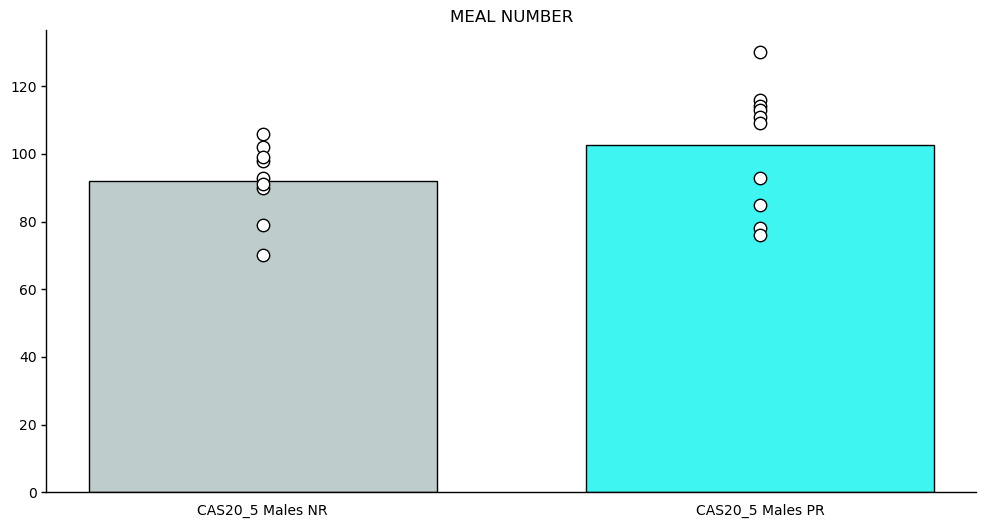

In [27]:
male_nr_nmeal = data[(data['SEX'] == 'M') & (data['DIET'] == 'NR') & (data["CHOICE_SESSION"] == 1)]['NUMBER_OF_MEALS'].tolist()
male_pr_nmeal = data[(data['SEX'] == 'M') & (data['DIET'] == 'PR') & (data["CHOICE_SESSION"] == 1)]['NUMBER_OF_MEALS'].tolist()
male_pr_nmeal
male_pr_nmeal 

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([male_nr_nmeal, male_pr_nmeal],
                                 ax=ax, paired=False, linewidth=1, groupwidth=0.9,barwidth=0.7,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20_5 Males NR", "CAS20_5 Males PR" ])

ax.set_title("MEAL NUMBER")

Text(0.5, 1.0, 'MEAL NUMBER')

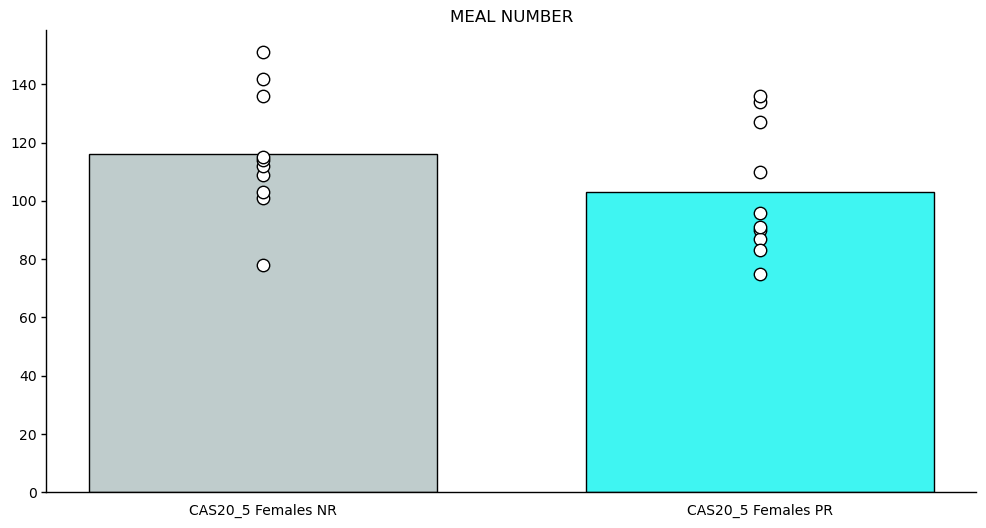

In [31]:
fmale_nr_nmeal = data[(data['SEX'] == 'F') & (data['DIET'] == 'NR') & (data["CHOICE_SESSION"] == 1)]['NUMBER_OF_MEALS'].tolist()
fmale_pr_nmeal = data[(data['SEX'] == 'F') & (data['DIET'] == 'PR') & (data["CHOICE_SESSION"] == 1)]['NUMBER_OF_MEALS'].tolist()

cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([fmale_nr_nmeal, fmale_pr_nmeal],
                                 ax=ax, paired=False, linewidth=1, groupwidth=0.9,barwidth=0.7,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20_5 Females NR", "CAS20_5 Females PR" ])

ax.set_title("MEAL NUMBER")

Text(0.5, 1.0, 'MEAL SIZE')

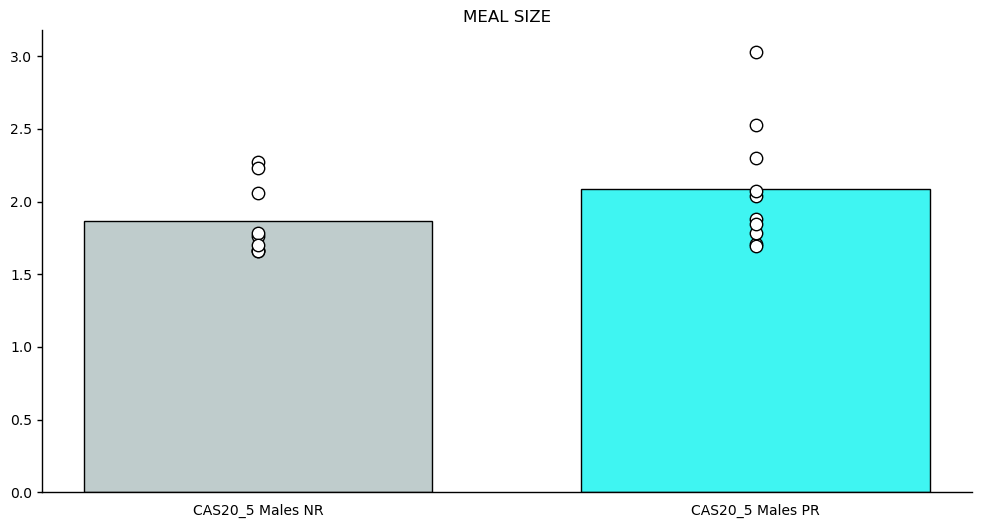

In [30]:
male_nr_smeal = data[(data['SEX'] == 'M') & (data['DIET'] == 'NR') & (data["CHOICE_SESSION"] == 1)]['MEAL_SIZE'].tolist()
male_pr_smeal = data[(data['SEX'] == 'M') & (data['DIET'] == 'PR') & (data["CHOICE_SESSION"] == 1)]['MEAL_SIZE'].tolist()


cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([male_nr_smeal, male_pr_smeal],
                                 ax=ax, paired=False, linewidth=1, groupwidth=0.9,barwidth=0.7,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20_5 Males NR", "CAS20_5 Males PR" ])

ax.set_title("MEAL SIZE")

Text(0.5, 1.0, 'MEAL SIZE')

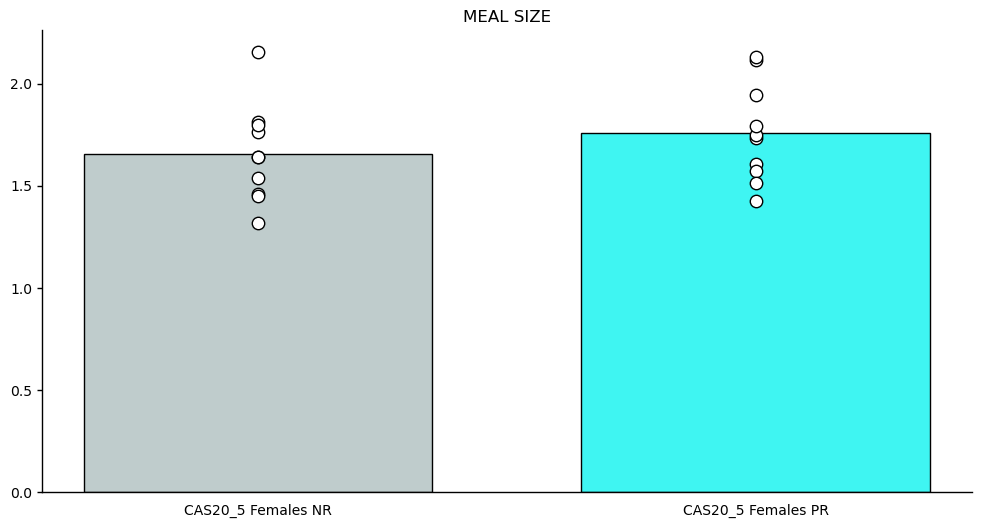

In [32]:
fmale_nr_smeal = data[(data['SEX'] == 'F') & (data['DIET'] == 'NR') & (data["CHOICE_SESSION"] == 1)]['MEAL_SIZE'].tolist()
fmale_pr_smeal = data[(data['SEX'] == 'F') & (data['DIET'] == 'PR') & (data["CHOICE_SESSION"] == 1)]['MEAL_SIZE'].tolist()


cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([fmale_nr_smeal, fmale_pr_smeal],
                                 ax=ax, paired=False, linewidth=1, groupwidth=0.9,barwidth=0.7,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20_5 Females NR", "CAS20_5 Females PR" ])

ax.set_title("MEAL SIZE")

Text(0.5, 1.0, 'MEAL FREQUENCY')

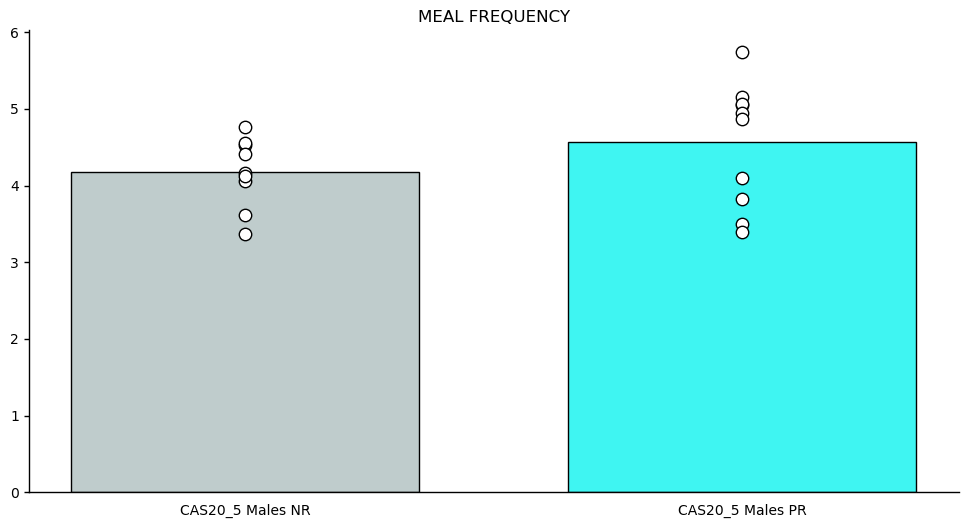

In [34]:
male_nr_fmeal = data[(data['SEX'] == 'M') & (data['DIET'] == 'NR') & (data["CHOICE_SESSION"] == 1)]['MEAL_FREQUENCY'].tolist()
male_pr_fmeal = data[(data['SEX'] == 'M') & (data['DIET'] == 'PR') & (data["CHOICE_SESSION"] == 1)]['MEAL_FREQUENCY'].tolist()


cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([male_nr_fmeal, male_pr_fmeal],
                                 ax=ax, paired=False, linewidth=1, groupwidth=0.9,barwidth=0.7,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20_5 Males NR", "CAS20_5 Males PR" ])

ax.set_title("MEAL FREQUENCY")

Text(0.5, 1.0, 'MEAL FREQUENCY')

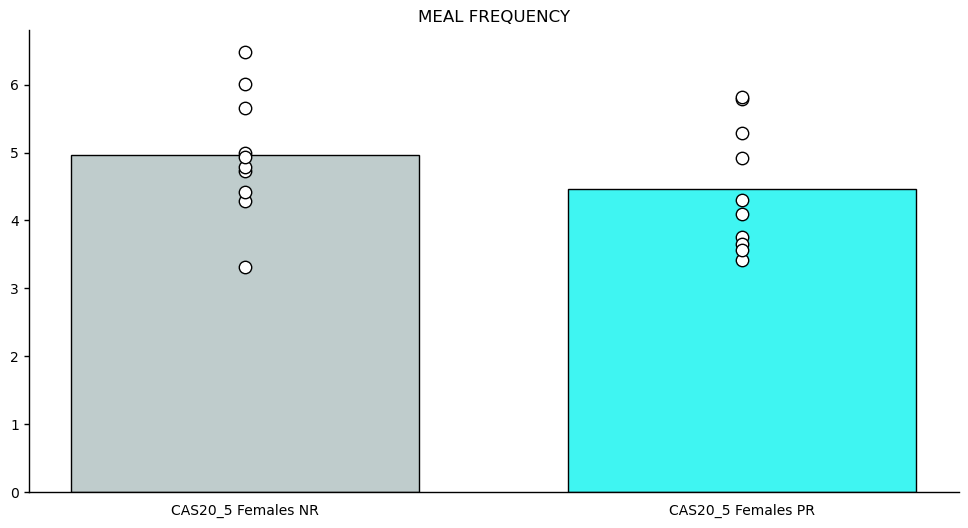

In [35]:
fmale_nr_fmeal = data[(data['SEX'] == 'F') & (data['DIET'] == 'NR') & (data["CHOICE_SESSION"] == 1)]['MEAL_FREQUENCY'].tolist()
fmale_pr_fmeal = data[(data['SEX'] == 'F') & (data['DIET'] == 'PR') & (data["CHOICE_SESSION"] == 1)]['MEAL_FREQUENCY'].tolist()


cas20_color_PR = (0.749, 0.8, 0.8)
cas5_color_PR = (0.247, 0.961, 0.949)
cas20_color_NR = (0.733, 0.839, 0.823)
cas5_color_NR = (0.549, 0.949, 0.945)




f, ax = plt.subplots(figsize=(12,6))
_, _, barlist, _ = tp.barscatter([fmale_nr_fmeal, fmale_pr_fmeal],
                                 ax=ax, paired=False, linewidth=1, groupwidth=0.9,barwidth=0.7,
                                 barfacecolor_option="individual",
                                 baredgecolor=["black"]*8,
                                 barfacecolor=[cas20_color_PR,cas5_color_PR,cas20_color_NR,cas5_color_NR],
                                 
                                 barlabels=["CAS20_5 Females NR", "CAS20_5 Females PR" ])

ax.set_title("MEAL FREQUENCY")

In [38]:
# plotting hour by hour meal numbers

file_path_meal_hour= "../results/MULTI_FED_HOUR_BY_HOUR_MEAL.csv"
data_meal_hour = pd.read_csv(file_path_meal_hour)
data_meal_hour


,MOUSE ID,SEX,DIET,CHOICE_SESSION,MEALS_HOUR_0,MEALS_HOUR_1,MEALS_HOUR_2,MEALS_HOUR_3,MEALS_HOUR_4,MEALS_HOUR_5,MEALS_HOUR_6,MEALS_HOUR_7,MEALS_HOUR_8,MEALS_HOUR_9,MEALS_HOUR_10,MEALS_HOUR_11,MEALS_HOUR_12,MEALS_HOUR_13,MEALS_HOUR_14,MEALS_HOUR_15,MEALS_HOUR_16,MEALS_HOUR_17,MEALS_HOUR_18,MEALS_HOUR_19,MEALS_HOUR_20,MEALS_HOUR_21,MEALS_HOUR_22,MEALS_HOUR_23
0,FEDXDF1,F,PR,1,7,0,4,10,13,0,0,7,0,0,3,0,5,5,4,6,7,9,9,6,9,6,0,0
1,FEDXDF1,F,PR,2,7,1,0,11,14,2,0,0,3,3,0,3,5,9,8,9,9,11,9,9,3,0,0,9
2,FEDXDF1,F,PR,3,9,0,4,1,9,17,8,2,0,4,1,6,11,14,11,13,11,12,12,10,4,0,0,7
3,FEDXDF1,F,PR,4,0,0,0,2,3,7,4,0,0,0,4,1,8,7,7,7,6,5,6,7,4,4,5,4
4,FEDXDF2,F,PR,1,3,0,7,9,4,2,0,1,2,5,0,3,8,5,5,5,4,6,6,4,5,6,0,0
5,FEDXDF2,F,PR,2,8,1,0,6,8,3,0,0,5,1,1,7,1,11,8,8,4,4,13,8,9,2,0,6
6,FEDXDF2,F,PR,3,5,1,9,0,4,8,2,0,2,3,3,4,5,12,9,3,11,11,9,9,0,0,6,0
7,FEDXDF2,F,PR,4,5,5,4,5,2,7,1,0,2,2,5,7,7,11,8,7,5,6,6,5,4,4,5,4
8,FEDXDF3,F,PR,1,3,9,9,6,7,11,0,0,4,0,1,5,8,8,7,5,8,9,7,8,6,5,1,0
9,FEDXDF3,F,PR,2,1,6,0,6,10,4,0,0,5,0,2,3,6,8,9,10,5,3,2,7,6,6,7,3


Text(0.5, 1.0, 'Meal per hour- males')

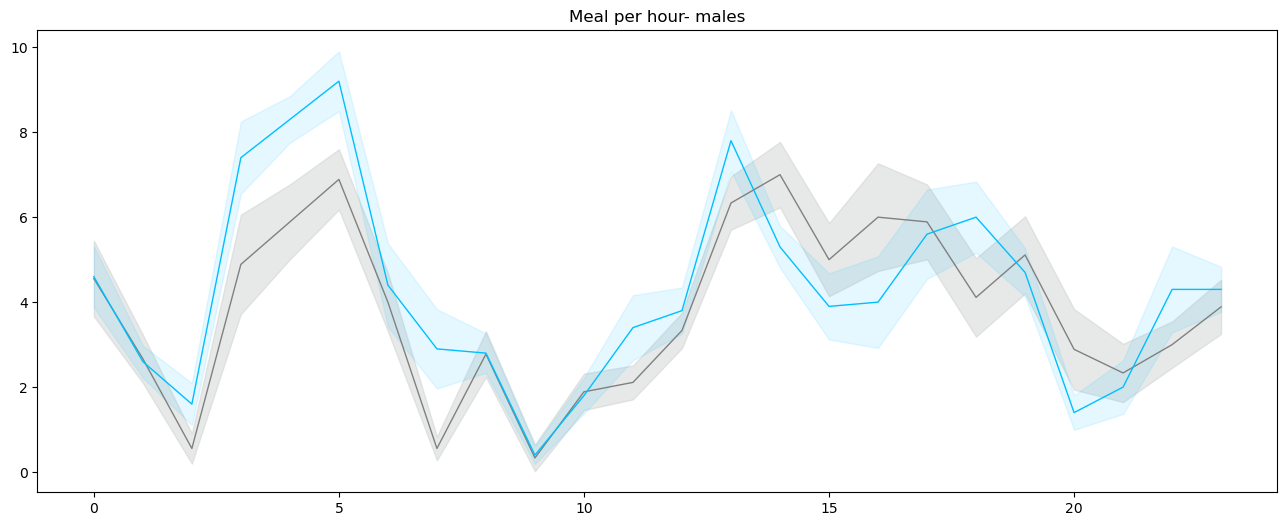

In [52]:
male_nr_hourly_C1 = data_meal_hour[(data_meal_hour['SEX'] == 'M') & (data_meal_hour['CHOICE_SESSION'] == 1) & (data_meal_hour['DIET'] == 'NR')].iloc[:, 4:]
male_pr_hourly_C1 = data_meal_hour[(data_meal_hour['SEX'] == 'M') & (data_meal_hour['CHOICE_SESSION'] == 1) & (data_meal_hour['DIET'] == 'PR')].iloc[:, 4:]
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,male_nr_hourly_C1,linecolor=ctl_color)
tp.shadedError(ax,male_pr_hourly_C1,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)
ax.set_title("Meal per hour- males")

Text(0.5, 1.0, 'Female per hour- males')

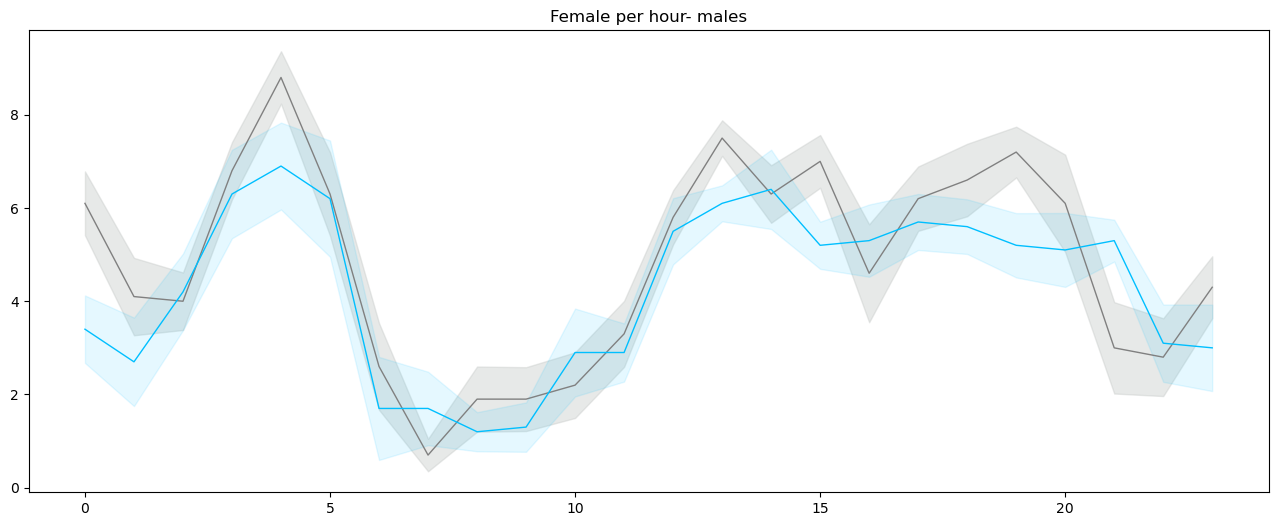

In [53]:
fmale_nr_hourly_C1 = data_meal_hour[(data_meal_hour['SEX'] == 'F') & (data_meal_hour['CHOICE_SESSION'] == 1) & (data_meal_hour['DIET'] == 'NR')].iloc[:, 4:]
fmale_pr_hourly_C1 = data_meal_hour[(data_meal_hour['SEX'] == 'F') & (data_meal_hour['CHOICE_SESSION'] == 1) & (data_meal_hour['DIET'] == 'PR')].iloc[:, 4:]
f, ax = plt.subplots(figsize=(16,6))
tp.shadedError(ax,fmale_nr_hourly_C1,linecolor=ctl_color)
tp.shadedError(ax,fmale_pr_hourly_C1,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)
ax.set_title("Female per hour- males")